# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is October 19**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name:Donia Gharbi **  
**Neptun ID: QNGHNC ** 

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem. 

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
import os    
import torch 
import torchvision
import pandas as pd  
import numpy as np  
from matplotlib import *
from torch.utils.data import Dataset, random_split, DataLoader  
from PIL import Image  
import torchvision.models as models  
import torchvision.transforms as transforms  
from torchvision import datasets  
import torch.nn.functional as F  
import torch.nn as nn  
from torchvision.utils import make_grid  
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt  
import random
from tensorflow.keras.utils import load_img
%matplotlib inline
import datetime

In [2]:
# hyperparameters
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [3]:
DEVICE = 'coda:0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [4]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42

## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading the dataset
Show some images and labels of your dataset

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
data_dir = "gdrive/MyDrive/Food101/"

#### Pre-processing the dataset

In [7]:
mean , std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transformed = transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

whole_data = datasets.ImageFolder(data_dir,transform=transformed)

In [8]:
len(whole_data)

2500

In [9]:
whole_data.classes

['baklava', 'bibimbap', 'cheesecake', 'chicken_curry', 'chocolate_mousse']

#### Splitting the dataset

In [10]:
train_dataset, rest_dataset = torch.utils.data.random_split(whole_data, [1500, 1000])
valid_dataset, test_dataset = torch.utils.data.random_split(rest_dataset, [500, 500])

In [11]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

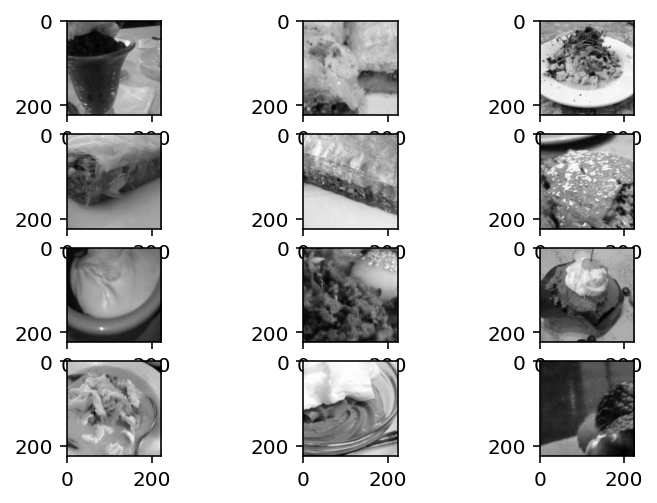

In [12]:
examples = iter(test_loader)
example_data, example_targets = examples.next()
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the architecture

In [13]:
model = models.mobilenet_v2(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [14]:
model.classifier[1] = nn.Linear(1280,5)

In [15]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

#### Define your optimizer and loss function

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

#### Train your network

In [17]:
class EarlyStopping():
   
    def __init__(self, patience=3, min_delta=0):
        
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = './cifar_best_net.pth'

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.best_model)
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter is {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [18]:
early_stopping = EarlyStopping()

In [19]:
def evaluate():
  running_loss = 0.0
  
  with torch.no_grad():
    for i, data in enumerate(valid_loader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
  val_loss = running_loss / len(valid_loader)
  print('loss Value : %.3f' % (val_loss))
  return val_loss


def eval_acc(train=False):
  correct = 0
  total = 0
  
  with torch.no_grad():
      loader = train_loader if train else valid_loader
      for data in loader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  
  print('The accuracy of the network on the %s images is  %d %%' % (
      'train' if train else 'test', 100 * correct / total))

In [20]:
model= model.to(device)
def train():
  NUM_EPOCHS = 15
  for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
      print(f'Epoch {epoch+1}:')
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
        
          inputs, labels = data[0].to(device), data[1].to(device) #set for GPU if available

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          if i % 250 == 0 and i!= 0: 
              print(f'Iteration {i}, loss = {(running_loss / 250):.3f}')
              running_loss = 0.0

      val_loss = evaluate()
      eval_acc()
      early_stopping(val_loss)
      if early_stopping.early_stop:
          break
  print('Finished Training')

#### Show results (accuracy and loss) on training and validation sets

In [21]:
train()

Epoch 1:
loss Value : 0.599
The accuracy of the network on the test images is  81 %
Epoch 2:
loss Value : 0.456
The accuracy of the network on the test images is  83 %
Epoch 3:
loss Value : 0.429
The accuracy of the network on the test images is  84 %
Epoch 4:
loss Value : 0.480
The accuracy of the network on the test images is  83 %
INFO: Early stopping counter is 1 of 3
Epoch 5:
loss Value : 0.415
The accuracy of the network on the test images is  85 %
Epoch 6:
loss Value : 0.418
The accuracy of the network on the test images is  85 %
INFO: Early stopping counter is 2 of 3
Epoch 7:
loss Value : 0.409
The accuracy of the network on the test images is  86 %
Epoch 8:
loss Value : 0.415
The accuracy of the network on the test images is  86 %
INFO: Early stopping counter is 3 of 3
INFO: Early stopping
Finished Training


## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

In [22]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        probs = model(images)
        _, predicted = torch.max(probs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f' The accuracy of the network on the test images is  {acc} %')

 The accuracy of the network on the test images is  86.0 %


#### Show some predictions

GroundTruth:  chocolate_mousse
Predicted:  cheesecake


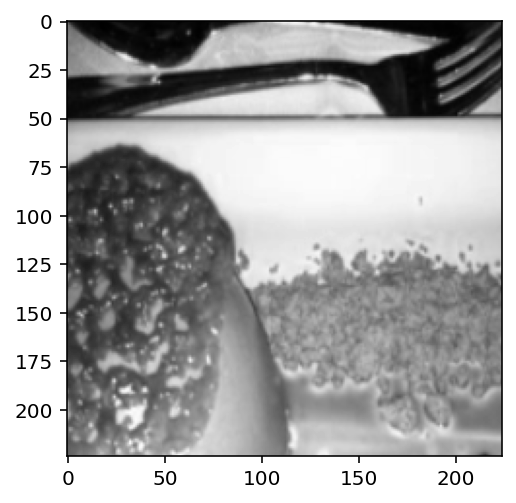

GroundTruth:  chocolate_mousse
Predicted:  chocolate_mousse


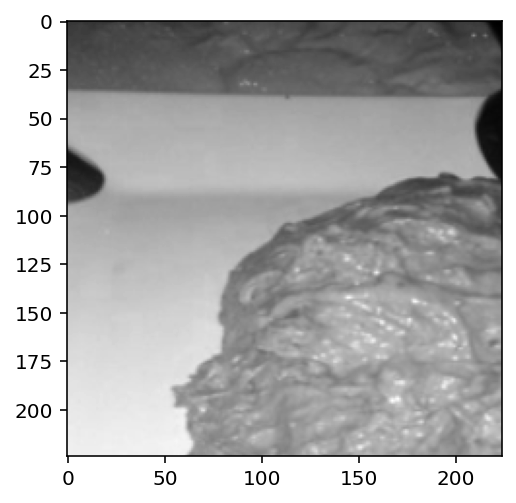

GroundTruth:  bibimbap
Predicted:  bibimbap


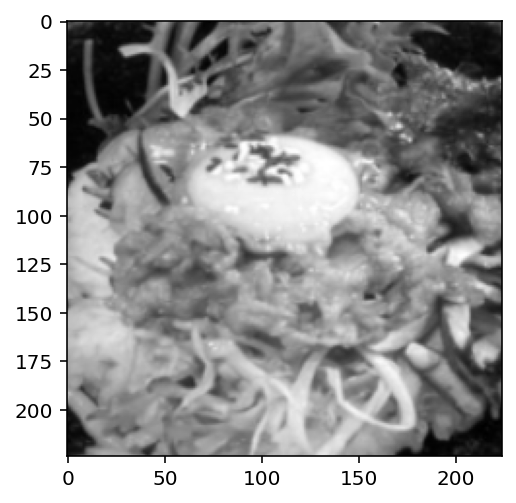

GroundTruth:  chicken_curry
Predicted:  chicken_curry


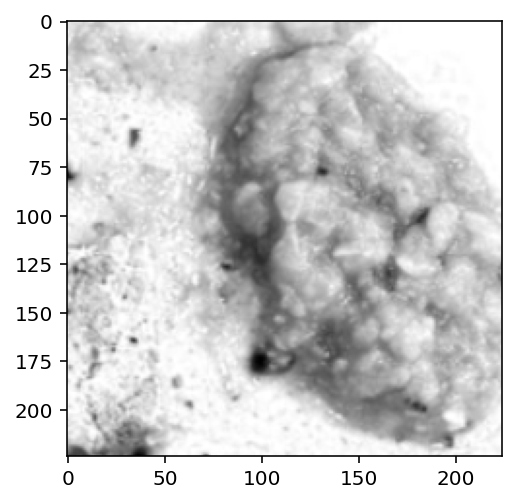

GroundTruth:  cheesecake
Predicted:  baklava


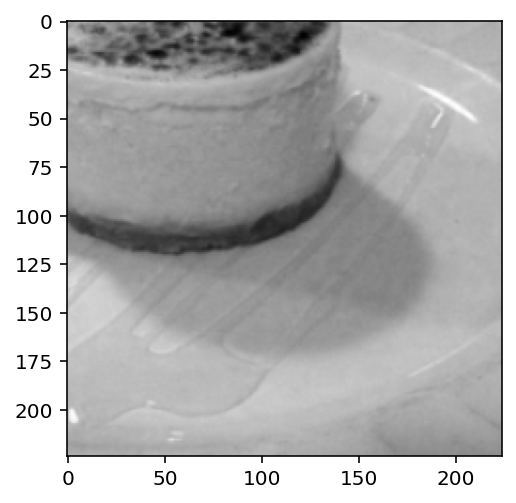

In [24]:
dataiter = iter(test_loader)
example_data, example_targets = examples.next()
classes = ("baklava", "bibimbap", "cheesecake", "chicken_curry", "chocolate_mousse")
outputs = model(images)
_, predicted = torch.max(outputs, 1)


# print images
for i in range(5):
  img = torchvision.utils.make_grid(example_data).numpy()
  plt.imshow(example_data[i][0], cmap='gray')
  print('GroundTruth: ', f'{classes[example_targets[i]]:5s}' )
  print('Predicted: ', f'{classes[predicted[i]]:5s}')
  plt.show()
#imshow(img)

#### Answer the questions

**How good are your results?**

I have used five classes from the original dataset and used a sample of each clas ( 500 images instead of 1000) due to computing problems. Despite that the accuracy of the network on the test images reached 86% . Which is already good enough of a result and it could possibly be improved if the whole dataset is used.

**Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.**

Through the results in the training phase it can be seen that the validation loss is not stable : it keeps increasing and decreasing (From 0.409 to  0.599) which indicates overfitting. Hence the funtion earlyStoppin has been used to stops the training when the loss does not improve after certain EPOCHS .